In [1]:
import torch
torch.cuda.empty_cache()

import gc
gc.collect()
torch.cuda.empty_cache()
!nvidia-smi

Mon Nov  4 20:08:08 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.94                 Driver Version: 560.94         CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3070 ...  WDDM  |   00000000:01:00.0  On |                  N/A |
| N/A   61C    P8             19W /   80W |     970MiB /   8192MiB |      9%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

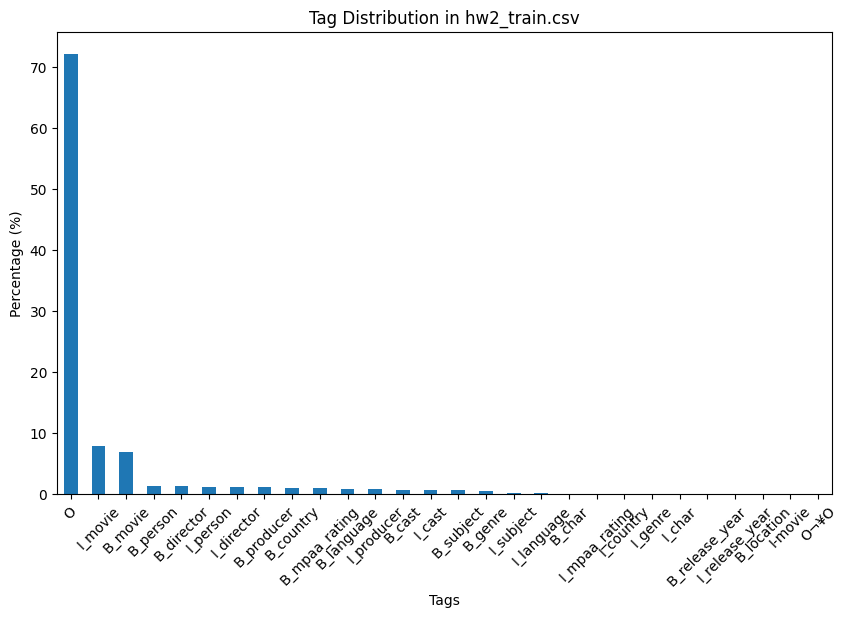

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

# 加載數據
train_df = pd.read_csv('./hw2_train.csv')

# 提取所有標籤
all_tags = train_df['IOB Slot tags'].str.split().sum()

# 計算各標籤的出現次數
tag_counts = pd.Series(all_tags).value_counts(normalize=True) * 100  # 轉換為百分比

# 繪製各標籤的佔比
plt.figure(figsize=(10, 6))
tag_counts.plot(kind='bar')
plt.xlabel('Tags')
plt.ylabel('Percentage (%)')
plt.title('Tag Distribution in hw2_train.csv')
plt.xticks(rotation=45)
plt.show()


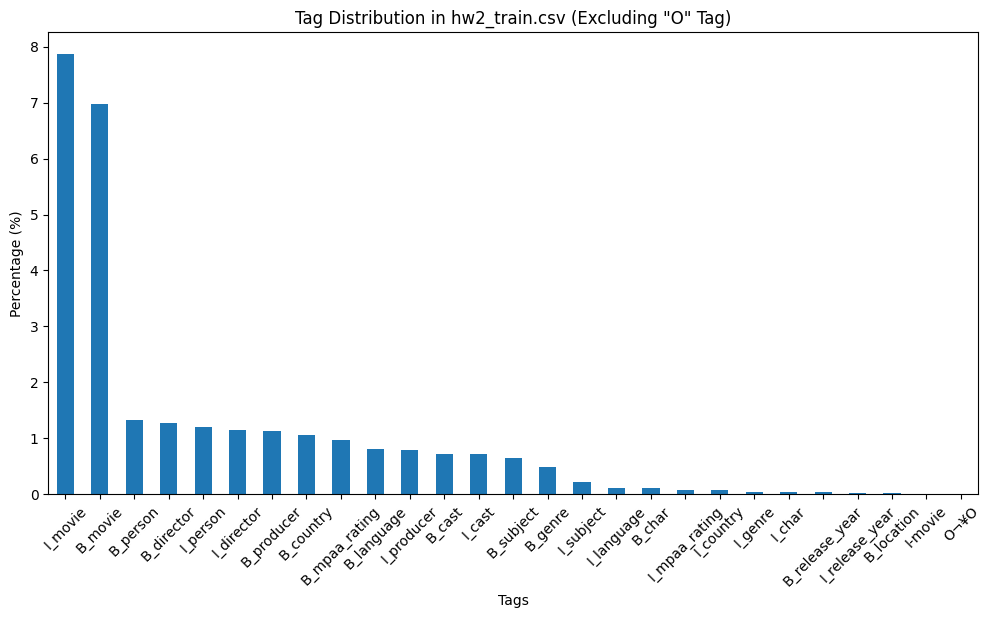

In [3]:
import pandas as pd
import matplotlib.pyplot as plt

# 加載數據
train_df = pd.read_csv('./hw2_train.csv')

# 提取所有標籤並排除 "O" 標籤
all_tags = train_df['IOB Slot tags'].str.split().sum()
tag_counts = pd.Series(all_tags).value_counts(normalize=True) * 100  # 轉換為百分比
tag_counts = tag_counts.drop(labels='O', errors='ignore')  # 排除 "O" 標籤

# 繪製各標籤的佔比
plt.figure(figsize=(12, 6))
tag_counts.plot(kind='bar')
plt.xlabel('Tags')
plt.ylabel('Percentage (%)')
plt.title('Tag Distribution in hw2_train.csv (Excluding "O" Tag)')
plt.xticks(rotation=45)
plt.show()


In [1]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from transformers import BertTokenizer, BertModel
from sklearn.model_selection import train_test_split
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import TensorDataset, DataLoader
from seqeval.metrics import classification_report, f1_score, precision_score, recall_score
import warnings
warnings.filterwarnings("ignore")

# 檢查是否有 GPU 可用
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("使用的設備:", device)

# 加載數據
train_df = pd.read_csv('hw2_train.csv')
print(train_df)

C:\Users\USER\anaconda3\envs\pytorch\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
C:\Users\USER\anaconda3\envs\pytorch\lib\site-packages\transformers\utils\generic.py:441: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
C:\Users\USER\anaconda3\envs\pytorch\lib\site-packages\transformers\utils\generic.py:309: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(


使用的設備: cuda
        ID                                         utterances  \
0        1               who plays luke on star wars new hope   
1        2                     show credits for the godfather   
2        3             who was the main actor in the exorcist   
3        4  find the female actress from the movie she 's ...   
4        5                    who played dory on finding nemo   
...    ...                                                ...   
2307  2308               what was the revenue for toy story 3   
2308  2309                                dark knight revenue   
2309  2310               how much did the dark night generate   
2310  2311                 can i see the lion king 's revenue   
2311  2312        can i see what the lion king 's revenue was   

                                      IOB Slot tags  
0      O O B_char O B_movie I_movie I_movie I_movie  
1                             O O O B_movie I_movie  
2                       O O O O O O B_movie I

In [2]:
# 初始化 BERT Tokenizer 和 Model
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
bert_model = BertModel.from_pretrained("bert-base-uncased").to(device)
# print("tokenizer = " , tokenizer)
# print("bert_model = " , bert_model)
# 設定最大序列長度
MAX_LENGTH = 32  # 可根據需要調整

In [3]:
# 調整 BERT 編碼函數
def encode_texts(texts, tokenizer, bert_model, device, max_length=MAX_LENGTH):
    inputs = tokenizer(
        texts, padding="max_length", truncation=True, max_length=max_length, return_tensors="pt"
    ).to(device)
    with torch.no_grad():
        outputs = bert_model(**inputs)
    embeddings = outputs.last_hidden_state  # Shape: (batch_size, max_length, hidden_dim)
    return embeddings, inputs["attention_mask"].sum(dim=1)

# 提取句子的 BERT 嵌入
utterances = train_df['utterances'].tolist()
embeddings, sequence_lengths = encode_texts(utterances, tokenizer, bert_model, device)
# print("embeddings = " ,embeddings)
# 構建標籤映射字典
unique_labels = set(label for tags in train_df['IOB Slot tags'] for label in tags.split())
label_to_index = {label: idx for idx, label in enumerate(unique_labels)}
idx_to_label = {idx: label for label, idx in label_to_index.items()}
# print("idx_to_label = " , idx_to_label)
# 將標籤轉換為數字格式並填充到 BERT 輸出的 max_length 長度
labels = train_df['IOB Slot tags'].apply(lambda x: [label_to_index[label] for label in x.split()])
labels_padded = pad_sequence(
    [torch.tensor(label + [label_to_index["O"]] * (MAX_LENGTH - len(label))) for label in labels], 
    batch_first=True
).to(device)

In [4]:
# 最後確認 BERT 嵌入與標籤的形狀一致
assert embeddings.shape[1] == labels_padded.shape[1], "BERT 輸出序列長度和標籤序列長度不匹配"
X_train, X_test, y_train, y_test = train_test_split(embeddings, labels_padded, test_size=0.2, random_state=42)

# 創建數據集和數據加載器
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [5]:
# # 定義 LSTM 模型來處理 BERT 輸出
# class SlotTaggingModel(nn.Module):
#     def __init__(self, bert_hidden_dim, hidden_dim, output_dim, dropout_prob=0.3):
#         super(SlotTaggingModel, self).__init__()
#         self.lstm = nn.LSTM(bert_hidden_dim, hidden_dim, batch_first=True)
#         self.dropout = nn.Dropout(dropout_prob)  # 新增Dropout層
#         self.fc = nn.Linear(hidden_dim, output_dim)
     
#     def forward(self, x):
#         lstm_out, _ = self.lstm(x)
#         lstm_out = self.dropout(lstm_out)  # 在LSTM輸出後應用Dropout
#         output = self.fc(lstm_out)
#         return output
class SlotTaggingModel(nn.Module):
    def __init__(self, bert_hidden_dim, hidden_dim, output_dim, dropout_prob=0.5):
        super(SlotTaggingModel, self).__init__()
        self.gru = nn.GRU(
            bert_hidden_dim, hidden_dim, num_layers=3, batch_first=True, bidirectional=True, dropout=dropout_prob
        )
        self.layer_norm = nn.LayerNorm(hidden_dim * 2)
        self.dropout = nn.Dropout(dropout_prob)
        self.attention = nn.Linear(hidden_dim * 2, 1)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)
    
    def forward(self, x):
        gru_out, _ = self.gru(x)
        gru_out = self.layer_norm(gru_out)
        gru_out = self.dropout(gru_out)
        
        # 注意力機制
        attn_weights = torch.softmax(self.attention(gru_out), dim=1)
        gru_out = gru_out * attn_weights
        output = self.fc(gru_out)
        return output


# # 初始化模型
bert_hidden_dim = embeddings.shape[2]
hidden_dim = 128
output_dim = len(label_to_index)
model = SlotTaggingModel(bert_hidden_dim, hidden_dim, output_dim).to(device)
# 印出所有可預測的標籤
print("模型可以預測的 Tags:")
for idx, label in idx_to_label.items():
    print(f"Index: {idx}, Tag: {label}")
# 定義損失函數和優化器
# criterion = nn.CrossEntropyLoss(ignore_index=label_to_index["O"])
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 訓練模型
def train_model(model, train_loader, criterion, optimizer, device):
    model.train()
    total_loss = 0.0
    for batch_x, batch_y in train_loader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
#         assert batch_x.shape[1] == batch_y.shape[1], "輸出序列長度和標籤序列長度不匹配"

        optimizer.zero_grad()
        outputs = model(batch_x).view(-1, output_dim)
        batch_y = batch_y.view(-1)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(train_loader)

# 調整後的評估模型
def evaluate_model(model, test_loader, criterion, device, idx_to_label):
    model.eval()
    total_loss = 0.0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch_x, batch_y in test_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            assert batch_x.shape[1] == batch_y.shape[1], "輸出序列長度和標籤序列長度不匹配"

            outputs = model(batch_x).view(-1, output_dim)
            batch_y = batch_y.view(-1)
            loss = criterion(outputs, batch_y)
            total_loss += loss.item()

            preds = torch.argmax(outputs, dim=1).cpu().numpy()
            labels = batch_y.cpu().numpy()

            # 將 index 轉換為對應的標籤
            preds = [idx_to_label[idx] for idx in preds]
            labels = [idx_to_label[idx] for idx in labels]

            all_preds.append(preds)
            all_labels.append(labels)

    avg_loss = total_loss / len(test_loader)
    
    # 使用 seqeval 計算精確度、召回率和 F1 分數
    report = classification_report(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds)
    recall = recall_score(all_labels, all_preds)

    print(f"Test Loss: {avg_loss:.4f}")
    print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}")
    print("Classification Report:\n", report)

    return avg_loss, precision, recall, f1



模型可以預測的 Tags:
Index: 0, Tag: I_country
Index: 1, Tag: O¬¥O
Index: 2, Tag: I_char
Index: 3, Tag: I-movie
Index: 4, Tag: B_person
Index: 5, Tag: I_director
Index: 6, Tag: B_producer
Index: 7, Tag: I_subject
Index: 8, Tag: B_mpaa_rating
Index: 9, Tag: B_country
Index: 10, Tag: B_char
Index: 11, Tag: B_language
Index: 12, Tag: I_movie
Index: 13, Tag: I_mpaa_rating
Index: 14, Tag: I_person
Index: 15, Tag: B_movie
Index: 16, Tag: B_subject
Index: 17, Tag: I_producer
Index: 18, Tag: I_release_year
Index: 19, Tag: B_genre
Index: 20, Tag: B_location
Index: 21, Tag: I_language
Index: 22, Tag: B_cast
Index: 23, Tag: B_director
Index: 24, Tag: I_genre
Index: 25, Tag: I_cast
Index: 26, Tag: O
Index: 27, Tag: B_release_year


In [6]:
# 訓練和評估過程
num_epochs = 200
for epoch in range(num_epochs):
    train_loss = train_model(model, train_loader, criterion, optimizer, device)
    test_loss, precision, recall, f1 = evaluate_model(model, test_loader, criterion, device, idx_to_label)
    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}')


Test Loss: 2.1048
Precision: 0.0000, Recall: 0.0000, F1 Score: 0.0000
Classification Report:
               precision    recall  f1-score   support

       _cast       0.00      0.00      0.00        18
       _char       0.00      0.00      0.00         1
    _country       0.00      0.00      0.00        23
   _director       0.00      0.00      0.00        32
      _genre       0.00      0.00      0.00        13
   _language       0.00      0.00      0.00        20
   _location       0.00      0.00      0.00         1
      _movie       0.00      0.00      0.00       217
_mpaa_rating       0.00      0.00      0.00        32
     _person       0.00      0.00      0.00        39
   _producer       0.00      0.00      0.00        38
    _subject       0.00      0.00      0.00        21

   micro avg       0.00      0.00      0.00       455
   macro avg       0.00      0.00      0.00       455
weighted avg       0.00      0.00      0.00       455

Epoch 1/200, Train Loss: 2.6623, Test L

In [5]:
from transformers import AdamW
from torch.optim.lr_scheduler import StepLR

class SlotTaggingModel(nn.Module):
    def __init__(self, bert_hidden_dim, hidden_dim, output_dim, dropout_prob=0.5):
        super(SlotTaggingModel, self).__init__()
        self.gru = nn.GRU(
            bert_hidden_dim, hidden_dim, num_layers=3, batch_first=True, bidirectional=True, dropout=dropout_prob
        )
        self.layer_norm = nn.LayerNorm(hidden_dim * 2)
        self.dropout = nn.Dropout(dropout_prob)
        self.attention = nn.Linear(hidden_dim * 2, 1)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)
    
    def forward(self, x):
        gru_out, _ = self.gru(x)
        gru_out = self.layer_norm(gru_out)
        gru_out = self.dropout(gru_out)
        
        # 注意力機制
        attn_weights = torch.softmax(self.attention(gru_out), dim=1)
        gru_out = gru_out * attn_weights
        output = self.fc(gru_out)
        return output

# 訓練模型
def train_model(model, train_loader, criterion, optimizer, device):
    model.train()
    total_loss = 0.0
    for batch_x, batch_y in train_loader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
#         assert batch_x.shape[1] == batch_y.shape[1], "輸出序列長度和標籤序列長度不匹配"

        optimizer.zero_grad()
        outputs = model(batch_x).view(-1, output_dim)
        batch_y = batch_y.view(-1)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(train_loader)
# 初始化模型
bert_hidden_dim = embeddings.shape[2]
hidden_dim = 128
output_dim = len(label_to_index)
model = SlotTaggingModel(bert_hidden_dim, hidden_dim, output_dim).to(device)

# 定義損失函數和優化器
criterion = nn.CrossEntropyLoss()  # 忽略 "O" 標籤的損失 ignore_index=label_to_index["O"]
optimizer = AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)  # 使用 AdamW 優化器
scheduler = StepLR(optimizer, step_size=5, gamma=0.5)  # 每 5 個 epoch 將學習率衰減 0.5 倍
# 調整後的評估模型
def evaluate_model(model, test_loader, criterion, device, idx_to_label):
    model.eval()
    total_loss = 0.0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch_x, batch_y in test_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            assert batch_x.shape[1] == batch_y.shape[1], "輸出序列長度和標籤序列長度不匹配"

            outputs = model(batch_x).view(-1, output_dim)
            batch_y = batch_y.view(-1)
            loss = criterion(outputs, batch_y)
            total_loss += loss.item()

            preds = torch.argmax(outputs, dim=1).cpu().numpy()
            labels = batch_y.cpu().numpy()

            # 將 index 轉換為對應的標籤
            preds = [idx_to_label[idx] for idx in preds]
            labels = [idx_to_label[idx] for idx in labels]

            all_preds.append(preds)
            all_labels.append(labels)

    avg_loss = total_loss / len(test_loader)
    
    # 使用 seqeval 計算精確度、召回率和 F1 分數
    report = classification_report(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds)
    recall = recall_score(all_labels, all_preds)

    print(f"Test Loss: {avg_loss:.4f}")
    print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}")
    print("Classification Report:\n", report)

    return avg_loss, precision, recall, f1

# 訓練和評估過程
num_epochs = 200
for epoch in range(num_epochs):
    train_loss = train_model(model, train_loader, criterion, optimizer, device)
    test_loss, precision, recall, f1 = evaluate_model(model, test_loader, criterion, device, idx_to_label)
    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}')
    scheduler.step()  # 更新學習率


Test Loss: 2.9597
Precision: 0.0000, Recall: 0.0000, F1 Score: 0.0000
Classification Report:
               precision    recall  f1-score   support

       _cast       0.00      0.00      0.00        18
       _char       0.00      0.00      0.00         1
    _country       0.00      0.00      0.00        23
   _director       0.00      0.00      0.00        32
      _genre       0.00      0.00      0.00        13
   _language       0.00      0.00      0.00        20
   _location       0.00      0.00      0.00         1
      _movie       0.00      0.00      0.00       217
_mpaa_rating       0.00      0.00      0.00        32
     _person       0.00      0.00      0.00        39
   _producer       0.00      0.00      0.00        38
    _subject       0.00      0.00      0.00        21

   micro avg       0.00      0.00      0.00       455
   macro avg       0.00      0.00      0.00       455
weighted avg       0.00      0.00      0.00       455

Epoch 1/200, Train Loss: 3.0902, Test L

In [7]:
# 載入測試數據
test_df = pd.read_csv('hw2_test.csv')
# 定義生成提交文件的函數
def generate_submission_file(model, test_df, tokenizer, bert_model, idx_to_label, device, output_file="submission_GRU.csv"):
    model.eval()
    predictions = []

    with torch.no_grad():
        for idx, row in test_df.iterrows():
            utterance = row["utterances"]
            
            # 1. 使用 BERT 將句子轉換為嵌入
            inputs = tokenizer(utterance, padding="max_length", truncation=True, max_length=128, return_tensors="pt").to(device)
            embeddings = bert_model(**inputs).last_hidden_state  # 取得 BERT 最後一層的輸出 (batch_size, seq_len, hidden_dim)
            
            # 2. 使用模型進行預測
            outputs = model(embeddings)  # 確認這裡的輸出是 (batch_size, seq_len, output_dim)
            
            # 3. 確保 outputs 的維度符合預期
            if outputs.dim() == 2:  # 當輸出只有 (seq_len, output_dim) 時進行擴展
                outputs = outputs.unsqueeze(0)  # 增加 batch 維度

            # 4. 獲取每個位置的預測標籤
            pred_labels = torch.argmax(outputs, dim=2).squeeze().cpu().numpy()
            pred_labels = [idx_to_label[label] for label in pred_labels[:len(inputs['input_ids'][0])]]

            # 5. 將子詞標籤整合成單詞標籤，處理 "O" 標籤
            tokens = tokenizer.tokenize(utterance)
            final_labels = []
            token_idx = 0

            for label in pred_labels:
                if token_idx >= len(tokens):
                    break  # 防止 token_idx 超出 tokens 的長度
                
                # 對於子詞，給出 "O" 標籤
                if tokens[token_idx].startswith("##"):
                    token_idx += 1
                    continue
                
                # 添加主詞的標籤，並在子詞中持續使用 "O" 標籤
                final_labels.append(label if label != "O" else "O")
                token_idx += 1

            # 6. 加入預測結果
            predictions.append(" ".join(final_labels))

    # 建立提交文件格式
    submission_df = pd.DataFrame({"ID": test_df["ID"], "IOB Slot tags": predictions})
    submission_df.to_csv(output_file, index=False)
    print(f"提交文件已生成：{output_file}")

# 確保標籤映射字典中包含 "O" 標籤
unique_labels = set(label for tags in train_df['IOB Slot tags'] for label in tags.split())
label_to_index = {label: idx for idx, label in enumerate(unique_labels)}
idx_to_label = {idx: label for label, idx in label_to_index.items()}

# 生成提交文件
generate_submission_file(model, test_df, tokenizer, bert_model, idx_to_label, device)


提交文件已生成：submission_GRU.csv


In [11]:
# 載入測試數據
test_df = pd.read_csv('hw2_test.csv')

# 定義生成提交文件的函數
def generate_submission_file(model, test_df, tokenizer, bert_model, idx_to_label, device, output_file="submission_1000.csv"):
    model.eval()
    predictions = []

    with torch.no_grad():
        for idx, row in test_df.iterrows():
            utterance = row["utterances"]
            
            # 1. 使用 BERT 將句子轉換為嵌入
            inputs = tokenizer(utterance, padding="max_length", truncation=True, max_length=128, return_tensors="pt").to(device)
            embeddings = bert_model(**inputs).last_hidden_state  # 取得 BERT 最後一層的輸出 (batch_size, seq_len, hidden_dim)
            
            # 2. 使用模型進行預測
            outputs = model(embeddings)  # 確認這裡的輸出是 (batch_size, seq_len, output_dim)
            
            # 3. 確保 outputs 的維度符合預期
            if outputs.dim() == 2:  # 當輸出只有 (seq_len, output_dim) 時進行擴展
                outputs = outputs.unsqueeze(0)  # 增加 batch 維度

            # 4. 獲取每個位置的預測標籤
            pred_labels = torch.argmax(outputs, dim=2).squeeze().cpu().numpy()
            pred_labels = [idx_to_label[label] for label in pred_labels[:len(inputs['input_ids'][0])]]

            # 5. 將子詞標籤整合成單詞標籤
            tokens = tokenizer.tokenize(utterance)
            final_labels = []
            token_idx = 0

            for label in pred_labels:
                if token_idx >= len(tokens):
                    break  # 防止 token_idx 超出 tokens 的長度
                
                # 跳過以 "##" 開頭的子詞標籤
                if tokens[token_idx].startswith("##"):
                    token_idx += 1
                    continue
                
                final_labels.append(label)
                token_idx += 1

            # 6. 加入預測結果
            predictions.append(" ".join(final_labels))

    # 建立提交文件格式
    submission_df = pd.DataFrame({"ID": test_df["ID"], "IOB Slot tags": predictions})
    submission_df.to_csv(output_file, index=False)
    print(f"提交文件已生成：{output_file}")

# 構建標籤映射字典
unique_labels = set(label for tags in train_df['IOB Slot tags'] for label in tags.split())
label_to_index = {label: idx for idx, label in enumerate(unique_labels)}
idx_to_label = {idx: label for label, idx in label_to_index.items()}

# 生成提交文件
generate_submission_file(model, test_df, tokenizer, bert_model, idx_to_label, device)


提交文件已生成：submission_1000.csv
